In [ ]:
#!pip3 install keras
#!pip uninstall tensorflow
#!pip install tensorflow==2.7.0

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from skimage import io
import pandas as pd
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model 
from tensorflow.keras.layers import *
from tensorflow.keras import layers, optimizers
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import seaborn as sns
import tensorflow as tf

In [ ]:
integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)','0': 'No tumor'}

In [ ]:
labels = np.load('/content/drive/MyDrive/labels.npy')
print(labels.shape)

(3064,)


In [ ]:
brain_df=pd.read_csv('/content/sample_data/brain_tumor_db.csv')

In [ ]:
labels1=[]
for i in range(98):
    labels1.append(0)

len(labels1)
labels=np.append(labels,labels1)   
brain_df['labels']=labels

number of No tumor: 98
number of meningioma (1): 708
number of glioma (2): 1426
number of pituitary tumor (3): 930


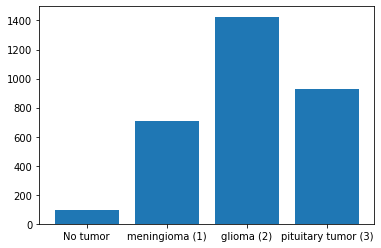

In [ ]:
#Analayzing Dat
classes, counts = np.unique(labels, return_counts=True)
plt.bar(classes, counts, 
        tick_label=['No tumor','meningioma (1)', 'glioma (2)', 'pituitary tumor (3)'])

for i, idx in enumerate(classes):
    print('number of {}: {}'.format(integer_to_class[str(idx)], counts[i]))

In [ ]:
brain_df.head()

,image,masks,labels
0,/Image/1.png,/Mask/1.png,1
1,/Image/2.png,/Mask/2.png,1
2,/Image/3.png,/Mask/3.png,1
3,/Image/4.png,/Mask/4.png,3
4,/Image/5.png,/Mask/5.png,3


In [ ]:
def display_mri_mask(df:pd.DataFrame, no_images = 12):
    count = 0
    fig, axs = plt.subplots(12, 3, figsize = (20, 50))  # default 12 rows and 3 columns each for MRI, MASK and MRI with MASK
    for i in range(len(df)):
        if df['labels'][i] == 3 and count < no_images:
            
            img_file=df.image[i]
            # Print MRIs without mask
            img = io.imread('/content/drive/MyDrive/' + img_file) # read image from path brain_df.image_path[i] and store its numerical/matrix representation into variable img 
            img=cv2.resize(img,(255,255))
            axs[count][0].title.set_text('Brain MRI') # Add Title to image
            axs[count][0].imshow(img) # Display Image
            
            mask_file=df.masks[i]
           # mask = io.imread(df.masks[i])  # same for mask
            mask = io.imread('/content/drive/MyDrive/'+ mask_file)
            mask=cv2.resize(mask,(255,255))
            axs[count][1].title.set_text('Mask') # add title
            axs[count][1].imshow(mask, cmap = 'gray') # display
            
            #print(img[mask])
            img[mask == 255] = (255) # highlighting tumor
            axs[count][2].title.set_text('MRI with Mask')
            axs[count][2].imshow(img)
            count+=1
    fig.tight_layout()       

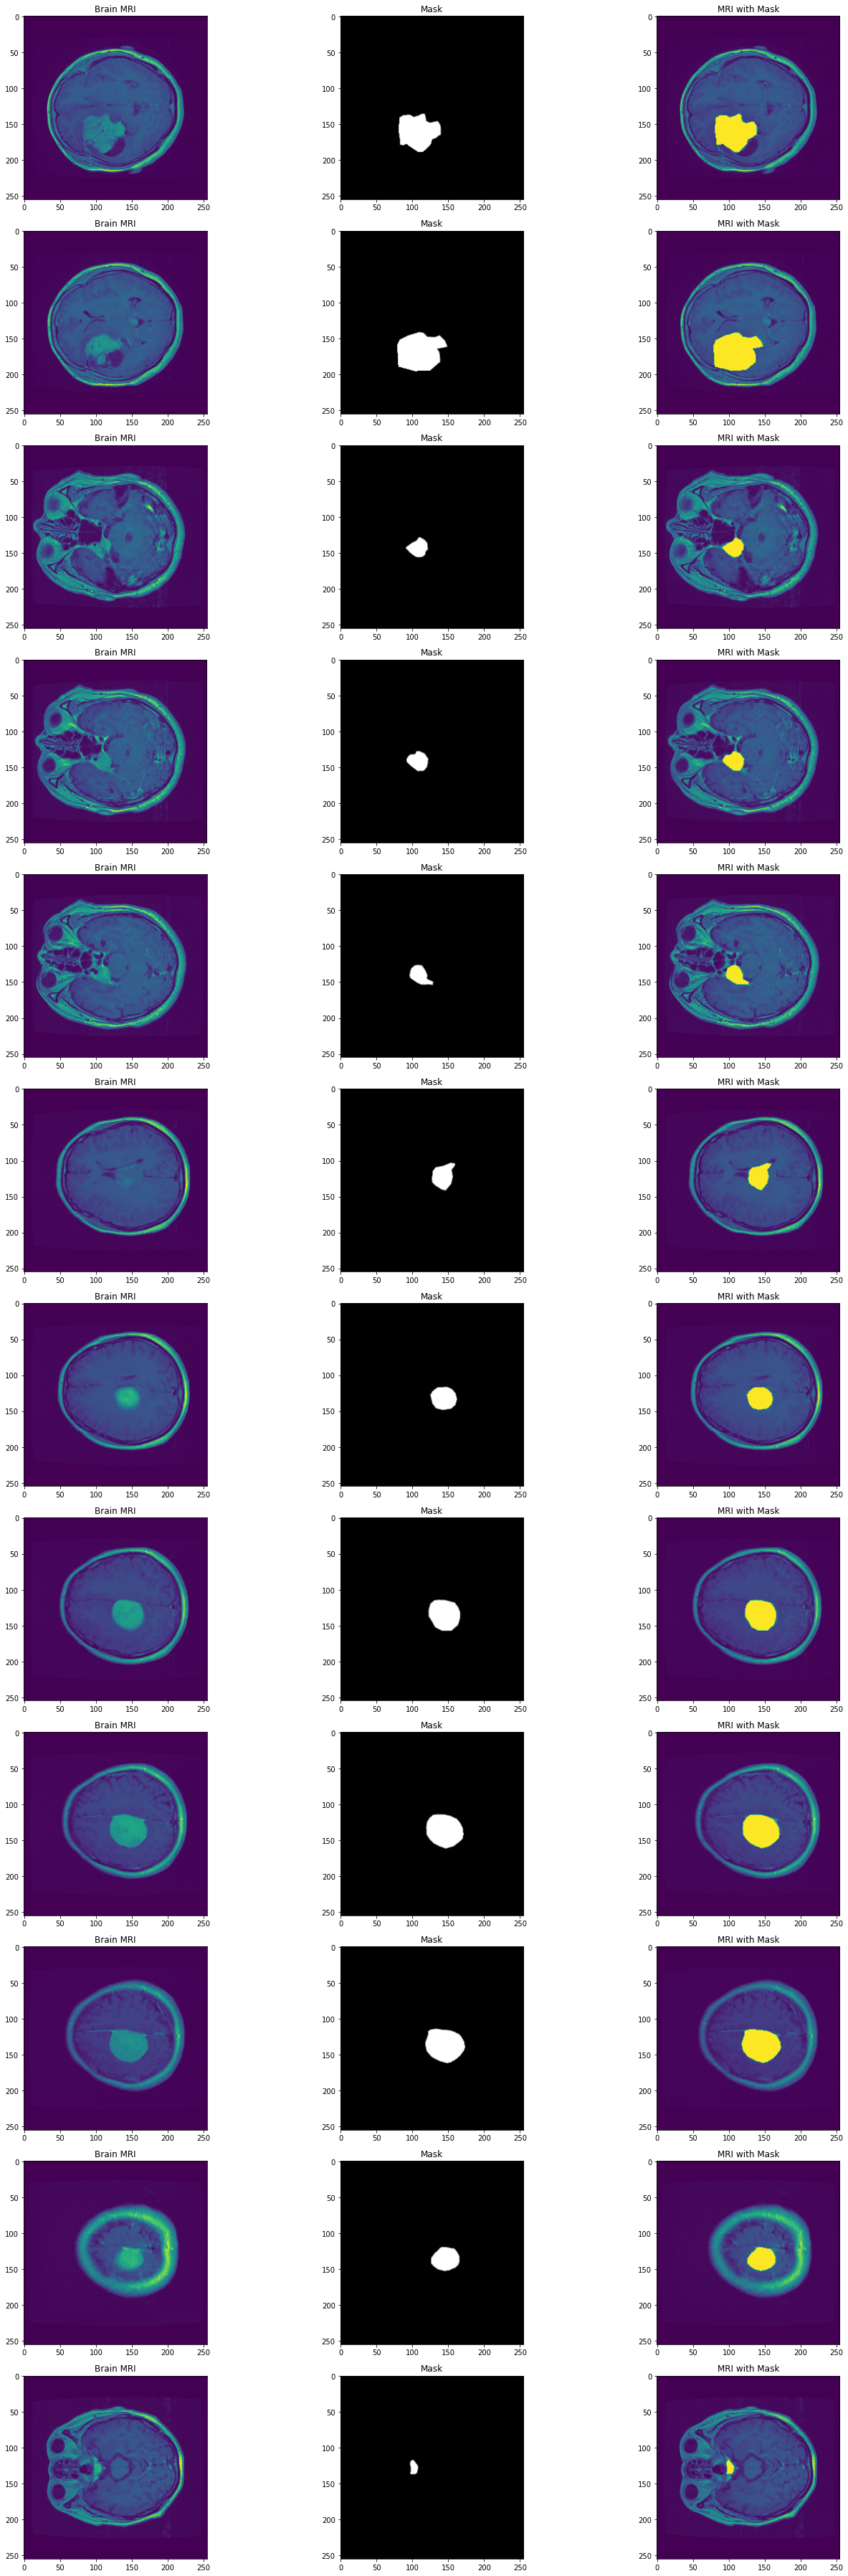

In [ ]:
display_mri_mask(brain_df)

In [ ]:
brain_df['labels'] = brain_df['labels'].apply(lambda x: str(x))

In [ ]:
#Image Augumentation

def train_val_test_data_gen(TRAIN:pd.DataFrame,TRAIN_PATH:str, VAL:pd.DataFrame, VAL_PATH:str, TEST:pd.DataFrame, 
                            TEXT_PATH:str, CLASS_MODE: str, BATCH_SIZE=16, IMAGE_SHAPE = (256,256)):
  
    print(TRAIN_PATH)
    # Create a data generator which scales the data in range  [0, 1] and makes validation split of 30%
    datagen = ImageDataGenerator(
                                 rescale=1./255., # normalize
                                 validation_split = 0.30)
    
    train_generator=datagen.flow_from_dataframe(
                                                    dataframe=TRAIN,
                                                    directory= TRAIN_PATH,
                                                    x_col='image',
                                                    y_col='labels',
                                                    subset="training",
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode=CLASS_MODE,
                                                    target_size=IMAGE_SHAPE)

    val_generator=datagen.flow_from_dataframe(
                                                    dataframe=VAL,
                                                    directory= VAL_PATH,
                                                    x_col='image',
                                                    y_col='labels',
                                                    subset="validation",
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode=CLASS_MODE,
                                                    target_size=IMAGE_SHAPE)

    # Create a data generator for test images
    test_datagen=ImageDataGenerator(rescale=1./255.)

    test_generator=test_datagen.flow_from_dataframe(
                                                    dataframe=TEST,
                                                    directory= TEXT_PATH,
                                                    x_col='image',
                                                    y_col='labels',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    class_mode=CLASS_MODE,
                                                    target_size=IMAGE_SHAPE)

    return train_generator, val_generator, test_generator

In [ ]:
#VGG16 Algorithm
train, test = train_test_split(brain_df, test_size = 0.23)
train['image'] =  '/content/drive/MyDrive' + train['image'].map(str)
test['image'] =  '/content/drive/MyDrive' + test['image'].map(str)
train['masks'] =  '/content/drive/MyDrive' + train['masks'].map(str)
test['masks'] =  '/content/drive/MyDrive' + test['masks'].map(str)
TRAIN = train
VAL = train
TEST = test
TRAIN_PATH = TEST_PATH = VAL_PATH = '/content/drive/MyDrive'
BATCH_SIZE = 16
CLASS_MODE = "categorical"
IMAGE_SHAPE = (224,224)
train_generator, valid_generator, test_generator = train_val_test_data_gen(TRAIN, 
                                                                           TRAIN_PATH, 
                                                                           VAL, 
                                                                           VAL_PATH, 
                                                                           TEST, 
                                                                           TEST_PATH, 
                                                                           CLASS_MODE, 
                                                                           BATCH_SIZE,
                                                                           IMAGE_SHAPE)

/content/drive/MyDrive
Found 1704 validated image filenames belonging to 4 classes.
Found 730 validated image filenames belonging to 4 classes.
Found 728 validated image filenames belonging to 4 classes.


In [ ]:
def lf_schedule(epoch,lr):
    if epoch%3 ==0:
        lr=lr - 0.05*lr #-->i.e. 0.95*lr (5% decay)
        print(f'New learning rate for epoch={epoch} is {lr}')
        return lr
    else:
        return lr

In [ ]:
def make_callback_earlystop(MODEL_WEIGHT_NAME:str):
    
    # use early stopping to exit training if validation loss is not decreasing even after certain epochs
    callback1 = EarlyStopping( monitor="val_accuracy", patience=2, verbose=1, mode="auto", min_delta=0)
    print(callback1)
    # If validation accuracy at current epoch is less than previous epoch accuracy, decrease the learning rate by factor of 10%. 
    callback2 = ReduceLROnPlateau( monitor="val_accuracy", factor=0.1, patience=1, verbose=1, mode="auto")
    print(callback2)
    # For every 3rd epoch, decay learning rate by 5%
    callback3 = LearningRateScheduler( schedule=lf_schedule,verbose=1)
    print()
    # save the best model with least validation loss
    checkpointer = ModelCheckpoint(filepath=f"{MODEL_WEIGHT_NAME}.hdf5", monitor="val_accuracy", verbose=1, save_best_only=True, mode="auto")
    return checkpointer, callback1, callback2, callback3

In [ ]:
def model1_vgg16():
    base_model_1 = VGG16(weights="imagenet", include_top=False, input_tensor = Input(shape=(224, 224, 3)),classes =4)
    for layer in base_model_1.layers:
        layers.trainable = False
    # Add classification head to the basemodel
    head = base_model_1.output
    head = Flatten()(head)
    head = Dense(units=128,activation='relu',kernel_initializer="he_uniform")(head)
    head = Dense(4, activation = 'sigmoid')(head)
    model_vgg = Model(inputs = base_model_1.input, outputs = head)
    return model_vgg

In [ ]:
model_1_vgg_16 = model1_vgg16()
#sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
model_1_vgg_16.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics =['accuracy'])

In [ ]:
checkpointer, callback1, callback2, callback3 = make_callback_earlystop("model_1_vgg_16_weights")

In [ ]:
history_vgg = model_1_vgg_16.fit(train_generator, 
                    steps_per_epoch= train_generator.n // 16, 
                    epochs = 20, validation_data= valid_generator, 
                    validation_steps= valid_generator.n // 16, 
                    callbacks=[checkpointer, callback1, callback2, callback3])

New learning rate for epoch=0 is 0.0009500000451225787

Epoch 00001: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 1/20
106/106 [==============================] - ETA: 0s - loss: 1.3284 - accuracy: 0.4058
Epoch 00001: val_accuracy improved from -inf to 0.47778, saving model to model_1_vgg_16_weights.hdf5
106/106 [==============================] - 688s 6s/step - loss: 1.3284 - accuracy: 0.4058 - val_loss: 1.1240 - val_accuracy: 0.4778 - lr: 9.5000e-04

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 2/20
106/106 [==============================] - ETA: 0s - loss: 1.1652 - accuracy: 0.4443
Epoch 00002: val_accuracy improved from 0.47778 to 0.49167, saving model to model_1_vgg_16_weights.hdf5
106/106 [==============================] - 27s 250ms/step - loss: 1.1652 - accuracy: 0.4443 - val_loss: 1.0543 - val_accuracy: 0.4917 - lr: 9.5000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.00095000001601874

In [ ]:
# save the model architecture to json file for future use
model_json = model_1_vgg_16.to_json()
with open("classifier-vgg16-model1.json","w") as json_file:
      json_file.write(model_json)

In [ ]:
with open('classifier-vgg16-model1.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model1_vgg16 = tf.keras.models.model_from_json(json_savedModel)
model1_vgg16.load_weights('model_1_vgg_16_weights.hdf5')
model1_vgg16.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
def model_prediction(model, MODEL_NAME:str, test_generator, BINARY = False):
    test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)
    
    # Obtain the predicted class from the model prediction
    
    # Obtain the predicted class from the model prediction
    predict = []

    for i in test_predict:
        predict.append(str(np.argmax(i)))
    predict = np.asarray(predict)
    original = np.asarray(test['labels'])[:len(predict)]
            
    
    #since we have used test generator, it limited the images to len(predict), due to batch size
   # print(predict)
   # print(original)
    accuracy = accuracy_score(original, predict)
    
    print(MODEL_NAME,"accuracy:",np.round(accuracy*100,4),"%")
    
    # plotting the confusion matrix
    cm = confusion_matrix(original, predict)
    plt.figure(figsize = (7,7))
    sns.heatmap(cm, annot=True)
    print()
    report = classification_report(original, predict, labels = [0,1,2,3])
    print((report))

45/45 [==============================] - 198s 4s/step
VGG16 Model 1 accuracy: 77.2222 %

              precision    recall  f1-score   support

           0       0.88      0.83      0.86        18
           1       0.78      0.55      0.64       162
           2       0.75      0.91      0.83       324
           3       0.79      0.73      0.76       216

   micro avg       0.77      0.77      0.77       720
   macro avg       0.80      0.76      0.77       720
weighted avg       0.78      0.77      0.77       720



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


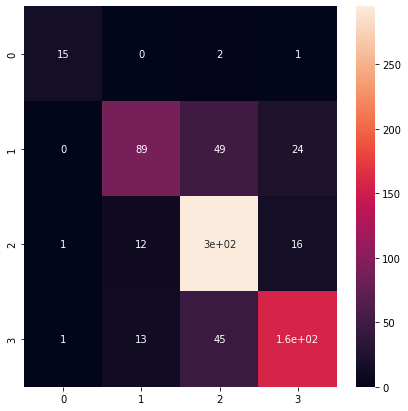

In [ ]:
model_prediction(model1_vgg16, "VGG16 Model 1", test_generator, False)

In [ ]:
#CNN Algorithm
train, test = train_test_split(brain_df, test_size = 0.23)
train['image'] =  '/content/drive/MyDrive' + train['image'].map(str)
test['image'] =  '/content/drive/MyDrive' + test['image'].map(str)
train['masks'] =  '/content/drive/MyDrive' + train['masks'].map(str)
test['masks'] =  '/content/drive/MyDrive' + test['masks'].map(str)
TRAIN = train
VAL = train
TEST = test
TRAIN_PATH = TEST_PATH = VAL_PATH = '/content/drive/MyDrive'
BATCH_SIZE = 16
CLASS_MODE = "categorical"
IMAGE_SHAPE = (224,224)
train_generator, valid_generator, test_generator = train_val_test_data_gen(TRAIN, 
                                                                           TRAIN_PATH, 
                                                                           VAL, 
                                                                           VAL_PATH, 
                                                                           TEST, 
                                                                           TEST_PATH, 
                                                                           CLASS_MODE, 
                                                                           BATCH_SIZE,
                                                                           IMAGE_SHAPE)

In [ ]:
def CNN_MODEL():
    model=Sequential()
    model.add(Conv2D(filters=32,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding="same",input_shape=(224,224,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=64,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding="same",input_shape=(224,224,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=128,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding="same",input_shape=(224,224,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units=128,activation="relu",kernel_initializer="he_uniform"))
    model.add(Dropout(0.5))
    model.add(Dense(units=4,activation="sigmoid"))
    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
    return model

In [ ]:
checkpointer, callback1, callback2, callback3 = make_callback_earlystop("CNN_MODEL_weights")

In [ ]:
model_cnn=CNN_MODEL()
history = model_cnn.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator),
                              validation_data=train_generator,
                              validation_steps=len(valid_generator),
                              epochs=20,
                              callbacks=[callback1,callback2,callback3])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


New learning rate for epoch=0 is 0.0009500000451225787

Epoch 00001: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 1/20
107/107 [==============================] - 18s 159ms/step - loss: 1.6519 - accuracy: 0.5158 - val_loss: 0.9800 - val_accuracy: 0.6943 - lr: 9.5000e-04

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 2/20
107/107 [==============================] - 16s 150ms/step - loss: 0.8795 - accuracy: 0.6614 - val_loss: 0.6909 - val_accuracy: 0.7826 - lr: 9.5000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 3/20
107/107 [==============================] - 16s 150ms/step - loss: 0.6888 - accuracy: 0.7441 - val_loss: 0.5764 - val_accuracy: 0.8071 - lr: 9.5000e-04
New learning rate for epoch=3 is 0.0009025000152178108

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009025000152178108.
Epoch 4/20
107/107 [==============================] - 16s 150ms/step

In [37]:
model_cnn.save_weights('CNN_MODEL_weights.hdf5')

In [38]:
model_json = model_cnn.to_json()
with open("CNN_MODEL.json","w") as json_file:
      json_file.write(model_json)

In [39]:
with open('CNN_MODEL.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('CNN_MODEL_weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

45/45 [==============================] - 5s 100ms/step
CNN Model accuracy: 81.8056 %

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.76      0.57      0.65       167
           2       0.83      0.88      0.85       328
           3       0.81      0.92      0.86       204

   micro avg       0.82      0.82      0.82       720
   macro avg       0.85      0.82      0.83       720
weighted avg       0.81      0.82      0.81       720



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


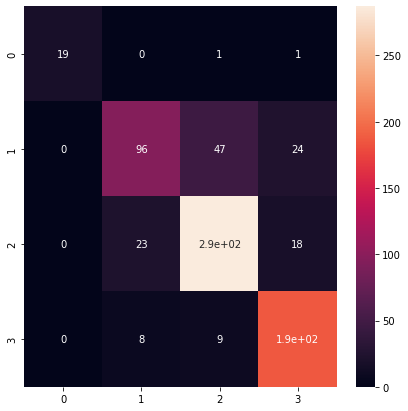

In [40]:
model_prediction(model, "CNN Model", test_generator,False)

In [41]:
#Vgg16 Model 2
train, test = train_test_split(brain_df, test_size = 0.23)
train['image'] =  '/content/drive/MyDrive' + train['image'].map(str)
test['image'] =  '/content/drive/MyDrive' + test['image'].map(str)
train['masks'] =  '/content/drive/MyDrive' + train['masks'].map(str)
test['masks'] =  '/content/drive/MyDrive' + test['masks'].map(str)
TRAIN = train
VAL = train
TEST = test
TRAIN_PATH = TEST_PATH = VAL_PATH = '/content/drive/MyDrive'
BATCH_SIZE = 16
CLASS_MODE = "categorical"
IMAGE_SHAPE = (224,224)
train_generator, valid_generator, test_generator = train_val_test_data_gen(TRAIN, 
                                                                           TRAIN_PATH, 
                                                                           VAL, 
                                                                           VAL_PATH, 
                                                                           TEST, 
                                                                           TEST_PATH, 
                                                                           CLASS_MODE, 
                                                                           BATCH_SIZE,
                                                                           IMAGE_SHAPE)

/content/drive/MyDrive
Found 1704 validated image filenames belonging to 4 classes.
Found 730 validated image filenames belonging to 4 classes.
Found 728 validated image filenames belonging to 4 classes.


In [42]:
checkpointer, callback1, callback2, callback3 = make_callback_earlystop("vgg16-model2-transfer-learning")

In [43]:
##VGG16 Second Model
def VGG_MODEL_2():    
    model=VGG16(include_top=False,input_shape=(224,224,3))
    for layer in model.layers:
        layer.trainable=False
    flat = Flatten()(model.layers[-1].output)
    classifier = Dense(units=128,activation='relu',kernel_initializer="he_uniform")(flat)
    output = Dense(units=4,activation="sigmoid")(classifier)
    model = Model(inputs=model.inputs,outputs=output)
    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
    return model

In [44]:
model=VGG_MODEL_2()
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator),
                              validation_data=train_generator,
                              validation_steps=len(valid_generator),
                              epochs=20,
                              callbacks=[callback1,callback2,callback3])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


New learning rate for epoch=0 is 0.0009500000451225787

Epoch 00001: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 1/20
107/107 [==============================] - 20s 171ms/step - loss: 1.2186 - accuracy: 0.6115 - val_loss: 0.8707 - val_accuracy: 0.6753 - lr: 9.5000e-04

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 2/20
107/107 [==============================] - 17s 154ms/step - loss: 0.6195 - accuracy: 0.7658 - val_loss: 0.5848 - val_accuracy: 0.7378 - lr: 9.5000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 3/20
107/107 [==============================] - 17s 155ms/step - loss: 0.4808 - accuracy: 0.8175 - val_loss: 0.4536 - val_accuracy: 0.8342 - lr: 9.5000e-04
New learning rate for epoch=3 is 0.0009025000152178108

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009025000152178108.
Epoch 4/20
107/107 [==============================] - 17s 155ms/step

In [48]:
model.save_weights('vgg16-model2-transfer-learning.hdf5')

In [49]:
model_json = model.to_json()
with open("classifier-vgg16-model2-transfer-learning.json","w") as json_file:
      json_file.write(model_json)

In [50]:
# Load pretrained model (instead of training the model for 1+ hours) 
with open('classifier-vgg16-model2-transfer-learning.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('vgg16-model2-transfer-learning.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

45/45 [==============================] - 5s 110ms/step
VGG16 Model-2 accuracy: 81.3889 %

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.68      0.57      0.62       145
           2       0.82      0.89      0.85       318
           3       0.84      0.85      0.85       230

   micro avg       0.81      0.81      0.81       720
   macro avg       0.84      0.83      0.83       720
weighted avg       0.81      0.81      0.81       720



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


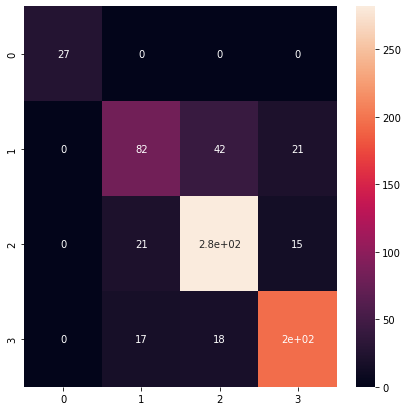

In [51]:
model_prediction(model, "VGG16 Model-2", test_generator,False)

In [53]:
#SVM
x_brain_df=brain_df.iloc[:,:-1]
y_brain_df=brain_df.iloc[:,-1]

In [54]:
x_brain_df.head()

,image,masks
0,/Image/1.png,/Mask/1.png
1,/Image/2.png,/Mask/2.png
2,/Image/3.png,/Mask/3.png
3,/Image/4.png,/Mask/4.png
4,/Image/5.png,/Mask/5.png


In [55]:
path1=('/content/drive/MyDrive/Image')
X=[]
count=1
for j in os.listdir(path1):
    img=cv2.imread(path1+'/'+j,0)
    img=cv2.resize(img,(200,200))
    if count < 3163:
      X.append(img)
      count=count+1


In [56]:
X=np.array(X)

In [57]:
X.shape

(3162, 200, 200)

In [ ]:
x_updated=X.reshape(len(X),-1)
x_updated.shape

In [59]:
xtrain,xtest,ytrain,ytest = train_test_split(x_updated,y_brain_df,random_state=10, test_size = 0.23)
xtrain.shape,xtest.shape

((2434, 40000), (728, 40000))

In [ ]:
ytrain.shape,xtrain.shape

In [ ]:
#Feature Scalling

print(xtrain.max(),xtrain.min())
print(xtest.max(),xtest.min())
xtrain=xtrain/255
xtest=xtest/255
print(xtrain.max(),xtrain.min())
print(xtest.max(),xtest.min())

In [ ]:
xtrain.shape

In [63]:
from sklearn.svm import SVC
sv=SVC()
sv.fit(xtrain,ytrain)

SVC()

In [64]:
print("Training Score:",sv.score(xtrain,ytrain))
print("Testing Score:",sv.score(xtest,ytest))

Training Score: 0.8512736236647493
Testing Score: 0.7472527472527473


In [65]:
pred=sv.predict(xtest)
np.where(ytest!=pred)

(array([  8,  10,  14,  16,  17,  18,  20,  23,  27,  28,  35,  39,  41,
         43,  47,  52,  54,  65,  69,  72,  74,  76,  77,  80,  85,  89,
         90,  96,  98, 105, 107, 114, 116, 125, 129, 130, 139, 140, 145,
        148, 149, 151, 152, 153, 154, 155, 157, 162, 163, 166, 167, 180,
        181, 183, 185, 188, 191, 197, 198, 199, 208, 211, 216, 219, 225,
        228, 230, 234, 240, 241, 248, 250, 256, 258, 265, 272, 280, 289,
        290, 295, 296, 301, 314, 317, 322, 327, 333, 338, 342, 354, 355,
        361, 363, 367, 376, 379, 382, 391, 406, 409, 420, 425, 440, 444,
        445, 446, 452, 455, 456, 460, 464, 468, 470, 472, 479, 487, 495,
        499, 503, 504, 511, 514, 515, 517, 530, 531, 533, 539, 540, 541,
        548, 552, 556, 557, 559, 560, 563, 564, 565, 566, 569, 570, 574,
        577, 580, 581, 583, 584, 594, 595, 600, 603, 606, 608, 609, 614,
        618, 621, 630, 631, 632, 634, 637, 642, 644, 646, 655, 656, 661,
        663, 673, 677, 678, 684, 687, 700, 704, 713